In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn import hmm

### Datele date din problema:

In [2]:
# Hidden states (test difficulty)
states = ["Difficult", "Medium", "Easy"]
n_states = len(states)

# Observations (grades)
observations = ["FB", "B", "S", "NS"]
n_observations = len(observations)

start_probability = np.array([1/3, 1/3, 1/3])

transition_probability = np.array([
    [0.0, 0.5, 0.5],   # Difficult -> Medium/Easy
    [0.5, 0.25, 0.25], # Medium -> D/M/E
    [0.5, 0.25, 0.25]  # Easy -> D/M/E
])

emission_probability = np.array([
    [0.1, 0.2, 0.4, 0.3],   # Difficult
    [0.15, 0.25, 0.5, 0.1], # Medium
    [0.2, 0.3, 0.4, 0.1]    # Easy
])

In [3]:
model = hmm.CategoricalHMM(n_components=n_states)
model.startprob_ = start_probability
model.transmat_ = transition_probability
model.emissionprob_ = emission_probability

### Without hmm (bonus)

In [8]:
def forward_algorithm(obs_sequence, start_prob, trans_prob, emit_prob):
    T = len(obs_sequence)
    N = len(start_prob)
    
    alpha = np.zeros((T, N))
    
    for i in range(N):
        alpha[0][i] = start_prob[i] * emit_prob[i][obs_sequence[0]]
    
    for t in range(1, T):
        for j in range(N):
            alpha[t][j] = sum(alpha[t-1][i] * trans_prob[i][j] 
                             for i in range(N)) * emit_prob[j][obs_sequence[t]]
    
    prob = sum(alpha[T-1])
    return prob

def viterbi_algorithm(obs_sequence, start_prob, trans_prob, emit_prob):
    T = len(obs_sequence)
    N = len(start_prob)
    
    delta = np.zeros((T, N))
    psi = np.zeros((T, N), dtype=int)
    
    for i in range(N):
        delta[0][i] = start_prob[i] * emit_prob[i][obs_sequence[0]]
        psi[0][i] = 0
    
    for t in range(1, T):
        for j in range(N):
            probs = [delta[t-1][i] * trans_prob[i][j] for i in range(N)]
            delta[t][j] = max(probs) * emit_prob[j][obs_sequence[t]]
            psi[t][j] = np.argmax(probs)
    
    best_path = np.zeros(T, dtype=int)
    best_path[T-1] = np.argmax(delta[T-1])
    
    for t in range(T-2, -1, -1):
        best_path[t] = psi[t+1][best_path[t+1]]
    
    return best_path

observations_sequence = ["FB", "FB", "S", "B", "B", "S", "B", "B", "NS", "B", "B"]
obs_indices = [observations.index(o) for o in observations_sequence]

prob = forward_algorithm(obs_indices, start_probability, 
                        transition_probability, emission_probability)
print("P(observations) =", prob)

hidden_states = viterbi_algorithm(obs_indices, start_probability,
                                  transition_probability, emission_probability)
print("Most likely states:", [states[i] for i in hidden_states])

P(observations) = 1.68881451978758e-07
Most likely states: ['Difficult', 'Easy', 'Difficult', 'Easy', 'Difficult', 'Medium', 'Difficult', 'Easy', 'Difficult', 'Easy', 'Difficult']


In [4]:
observations_sequence = ["FB", "FB", "S", "B", "B", "S", "B", "B", "NS", "B", "B"]
X = np.array([[observations.index(o)] for o in observations_sequence], dtype=int)
logprob = model.score(X)
print("P(observations) =", np.exp(logprob))

hidden_states = model.predict(X)
print("Most likely states:", [states[i] for i in hidden_states])

P(observations) = 1.6888145197875796e-07
Most likely states: ['Easy', 'Easy', 'Difficult', 'Easy', 'Difficult', 'Medium', 'Difficult', 'Easy', 'Difficult', 'Easy', 'Difficult']


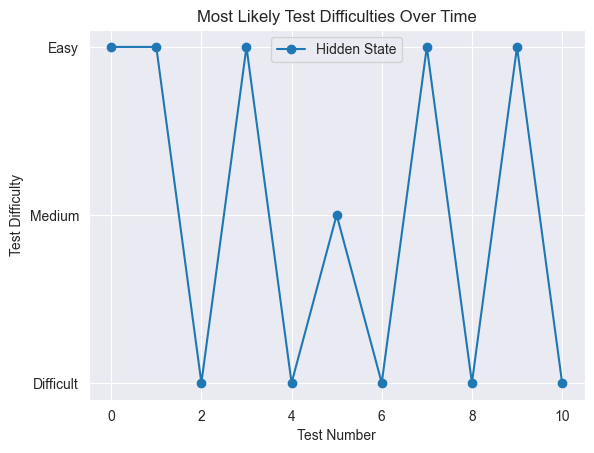

In [5]:
sns.set_style("darkgrid")
plt.plot(hidden_states, '-o', label="Hidden State")
plt.xlabel("Test Number")
plt.ylabel("Test Difficulty")
plt.yticks(ticks=range(n_states), labels=states)
plt.legend()
plt.title("Most Likely Test Difficulties Over Time")
plt.show()

C:\Users\claud\AppData\Local\Temp\ipykernel_43264\2750154656.py:27: RuntimeWarning: invalid value encountered in scalar divide
  dx, dy = dx/dist, dy/dist


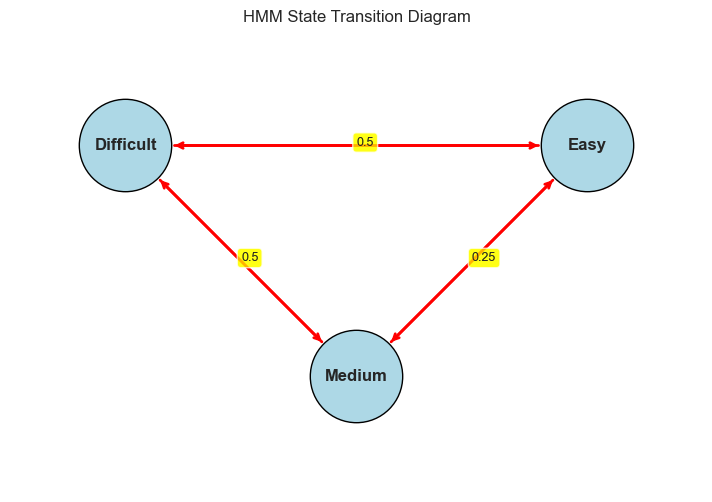


Emission Probabilities:
State		FB	B	S	NS
----------------------------------------
Difficult		0.10	0.20	0.40	0.30
Medium		0.15	0.25	0.50	0.10
Easy		0.20	0.30	0.40	0.10


In [6]:
fig, ax = plt.subplots(figsize=(10, 6))
pos = {'Difficult': (0, 1), 'Medium': (1, 0), 'Easy': (2, 1)}

for state, (x, y) in pos.items():
    circle = plt.Circle((x, y), 0.2, fill=True, edgecolor='black', facecolor='lightblue')
    ax.add_patch(circle)
    plt.text(x, y, state, ha='center', va='center', fontsize=12, fontweight='bold')

transitions = [
    ('Difficult', 'Medium', 0.5),
    ('Difficult', 'Easy', 0.5),
    ('Medium', 'Difficult', 0.5),
    ('Medium', 'Medium', 0.25),
    ('Medium', 'Easy', 0.25),
    ('Easy', 'Difficult', 0.5),
    ('Easy', 'Medium', 0.25),
    ('Easy', 'Easy', 0.25)
]

for from_state, to_state, prob in transitions:
    if prob > 0:
        x1, y1 = pos[from_state]
        x2, y2 = pos[to_state]
        
        dx, dy = x2 - x1, y2 - y1
        dist = np.sqrt(dx**2 + dy**2)
        dx, dy = dx/dist, dy/dist
        
        start_x, start_y = x1 + 0.2*dx, y1 + 0.2*dy
        end_x, end_y = x2 - 0.2*dx, y2 - 0.2*dy
        
        ax.annotate('', xy=(end_x, end_y), xytext=(start_x, start_y),
                   arrowprops=dict(arrowstyle='->', lw=2, color='red'))
        
        mid_x, mid_y = (start_x + end_x)/2, (start_y + end_y)/2
        plt.text(mid_x, mid_y, f'{prob}', 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
                fontsize=9)

ax.set_xlim(-0.5, 2.5)
ax.set_ylim(-0.5, 1.5)
ax.set_aspect('equal')
ax.axis('off')
plt.title('HMM State Transition Diagram')
plt.show()

print("\nEmission Probabilities:")
print("State\t\tFB\tB\tS\tNS")
print("-" * 40)
for i, state in enumerate(states):
    print(f"{state}\t\t{emission_probability[i][0]:.2f}\t{emission_probability[i][1]:.2f}\t{emission_probability[i][2]:.2f}\t{emission_probability[i][3]:.2f}")